<a href="https://colab.research.google.com/github/EiffL/LPTLensingComparison/blob/main/notebooks/AccuracyTest_Porqueres2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet git+https://github.com/Eiffl/LPTLensingComparison.git

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.5/531.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 76.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
%pylab inline

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95'

import jax
import jax.numpy as jnp
import jax_cosmo as jc

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Build Porqueres et al. (2023) simulation setting
# https://arxiv.org/abs/2304.04785

from scipy.stats import norm
z = linspace(0, 2.5, 1000)

nz_shear = [jc.redshift.kde_nz(z,
                               norm.pdf(z, loc=z_center, scale=0.12) ,
                               bw=0.01, zmax=2.5, gals_per_arcmin2=g )
                for z_center, g in zip([0.5, 1., 1.5, 2.], [7,8.5, 7.5, 7])]
nbins = len(nz_shear)

cosmo = jc.Planck15()
# Define the fiducial cosmology
Omega_b = 0.049
Omega_c = 0.315 - Omega_b
sigma_8 = 0.8
h = 0.677
n_s = 0.9624
w0 = -1
cosmo = jc.Cosmology(Omega_c=Omega_c, sigma8=sigma_8, Omega_b=Omega_b,
                      h=h, n_s=n_s, w0=w0, Omega_k=0., wa=0.)


# Specify the size and resolution of the patch to simulate
field_size = 16.   # transverse size in degrees
field_npix = 64    # number of pixels per side
sigma_e = 0.3
print("Pixel size in arcmin: ", field_size * 60 / field_npix)

Pixel size in arcmin:  15.0


/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Text(0.5, 1.0, 'Angular power spectrum')

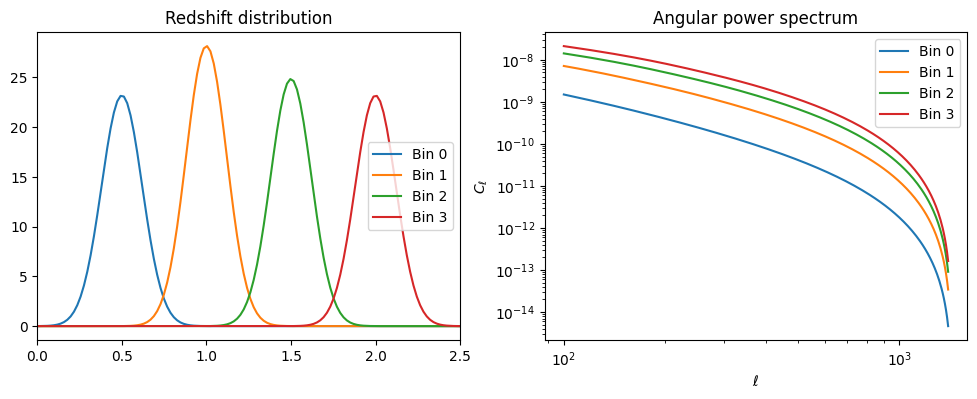

In [4]:
# Let's build a theory model
from jax_lensing.model import make_2pt_model

ell_theory = jnp.linspace(100, 1400, 128)

# Generate the forward model given these survey settings
theory_model = jax.jit(make_2pt_model(pixel_scale=field_size/field_npix*60,
                                      ell=ell_theory))

cell_theory, cell_noise = theory_model(cosmo, nz_shear)

figure(figsize=(12, 4))
subplot(121)
# Plotting the redshift distribution
z = linspace(0, 2.5, 128)

for i in range(nbins):
  plot(z, nz_shear[i](z)*nz_shear[i].gals_per_arcmin2, color='C%d'%i, label="Bin %d"%i)
legend()
xlim(0,2.5);
title('Redshift distribution')

subplot(122)

n = 0
for i in range(nbins):
    for j in range(i, nbins):
        if i==j:
            loglog(ell_theory, cell_theory[n], label="Bin %d"%i)
        n += 1
legend();
xlabel(r'$\ell$')
ylabel(r'$C_\ell$')
title('Angular power spectrum')

In [5]:
# Now, let's build a full field model
import numpyro
import numpyro.distributions as dist
from jax_lensing.model import make_full_field_model

box_size  = [1000., 1000., 4500.]   # In Mpc/h
box_shape = [64,  64,  128]         # Number of voxels/particles per side

# Generate the forward model given these survey settings
lensing_model = jax.jit(make_full_field_model( field_size=field_size,
                                            field_npix=field_npix,
                                            box_size=box_size,
                                            box_shape=box_shape))
# Define the probabilistic model
def model():
  """
  This function defines the top-level forward model for our observations
  """
  # Sampling initial conditions
  initial_conditions = numpyro.sample('initial_conditions', dist.Normal(jnp.zeros(box_shape),
                                                                        jnp.ones(box_shape)))
  # Generate random convergence maps
  convergence_maps, _ = lensing_model(cosmo, nz_shear, initial_conditions)

  # Apply noise to the maps (this defines the likelihood)
  observed_maps = [numpyro.sample('kappa_%d'%i,
                                  dist.Normal(k, sigma_e/jnp.sqrt(nz_shear[i].gals_per_arcmin2*(field_size*60/field_npix)**2)))
                   for i,k in enumerate(convergence_maps)]

  return observed_maps

In [6]:
# sample a mass map and save corresponding true parameters
model_tracer = numpyro.handlers.trace(numpyro.handlers.seed(model, jax.random.PRNGKey(1234)))
model_trace = model_tracer.get_trace()

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


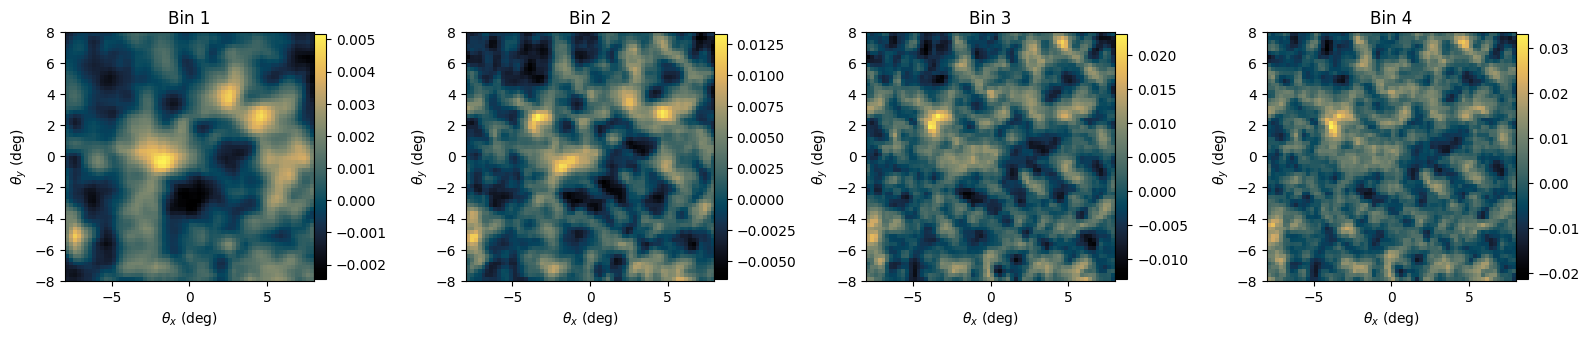

In [7]:
# Plotting utils
import cmasher as cmr
EXTENT = (-0.5 * field_size, 0.5 * field_size, -0.5 * field_size, 0.5 * field_size)
cmap = cmr.eclipse

fig, ax = plt.subplots(1,nbins, figsize=(4 * nbins, 7))
for i in range(nbins):
    std_kmap = np.std(model_trace['kappa_%d'%i]['fn'].mean)
    ax[i].set_title('Bin %d'%(i+1))
    ax[i].set_xlabel(r'$\theta_x$ (deg)')
    ax[i].set_ylabel(r'$\theta_y$ (deg)')
    cb = fig.colorbar(ax[i].imshow(model_trace['kappa_%d'%i]['fn'].mean, cmap=cmap,  extent=EXTENT) ,fraction=0.047, pad=0.)
    cb.ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

### Compare the results with the theory

In [9]:
# Compute the power spectra and cross correlations of all maps
from lenstools import ConvergenceMap
import astropy.units as u
import itertools

N_sample = 100

Cl_list = []
for i in range(N_sample):
    model_trace = model_tracer.get_trace()
    m_data = jnp.stack([model_trace['kappa_0']['fn'].mean,
                        model_trace['kappa_1']['fn'].mean,
                        model_trace['kappa_2']['fn'].mean,
                        model_trace['kappa_3']['fn'].mean], axis=0)
    Cl_list.append(m_data)

l_edges_kmap= np.linspace(50, 1000, 10)
lis=[0,1,2,3,4]
p_cross_sample=[]
for k in range(N_sample):
    m_data=Cl_list[k]
    p_cross=[]
    for i, j in itertools.combinations(lis, 2):
        pi=ConvergenceMap(m_data[i], angle=field_size*u.deg).cross(ConvergenceMap(m_data[j], angle=field_size*u.deg),l_edges=l_edges_kmap)[1]
        p_cross.append(pi)
    p_cross_sample.append(p_cross)
ell_sample=ConvergenceMap(m_data[0], angle=field_size*u.deg).cross(ConvergenceMap(m_data[0], angle=field_size*u.deg),l_edges=l_edges_kmap)[0]


p_auto_sample=[]
for k in range(N_sample):
    m_data=Cl_list[k]
    p_auto=[]
    for i in range(nbins):
        pi=ConvergenceMap(m_data[i], angle=field_size*u.deg).powerSpectrum(l_edges_kmap)[1]
        p_auto.append(pi)
    p_auto_sample.append(p_auto)

#some useful functions to make the plot
def fill_lower_and_diag(array,nl):
    n = int(np.sqrt(len(array)*2))
    mask = np.arange(n)[:,None] >= np.arange(n)
    out = np.zeros((n,n,nl),dtype=float64)
    out[np.stack(mask,axis=1)] = array
    return out.T


def fill_lower_diag(array,nl):
    n = int(np.sqrt(len(array)*2))+1
    mask = np.arange(n)[:,None] > np.arange(n)
    out = np.zeros((n,n, nl),dtype=float64)
    out[np.stack(mask,axis=1)] = array
    return out.T

Cl_cross_arr = np.array(p_cross_sample)
Cl_mean_cross  = np.mean(Cl_cross_arr, axis=0)
Cl_lower_cross = np.percentile(Cl_cross_arr, 2.5, axis=0)
Cl_upper_cross = np.percentile(Cl_cross_arr, 97.5, axis=0)

Cl_auto_arr = np.array(p_auto_sample)
Cl_mean_auto  = np.mean(Cl_auto_arr, axis=0)
Cl_lower_auto = np.percentile(Cl_auto_arr, 2.5, axis=0)
Cl_upper_auto = np.percentile(Cl_auto_arr, 97.5, axis=0)

Cl_mean_sample_cross=fill_lower_diag(Cl_mean_cross,9)
Cl_lower_sample_cross=fill_lower_diag(Cl_lower_cross,9)
Cl_upper_sample_cross=fill_lower_diag(Cl_upper_cross,9)

Cl_mean_theory=fill_lower_and_diag(cell_theory,128)
Cl_noise_theory=fill_lower_and_diag(cell_noise,128)

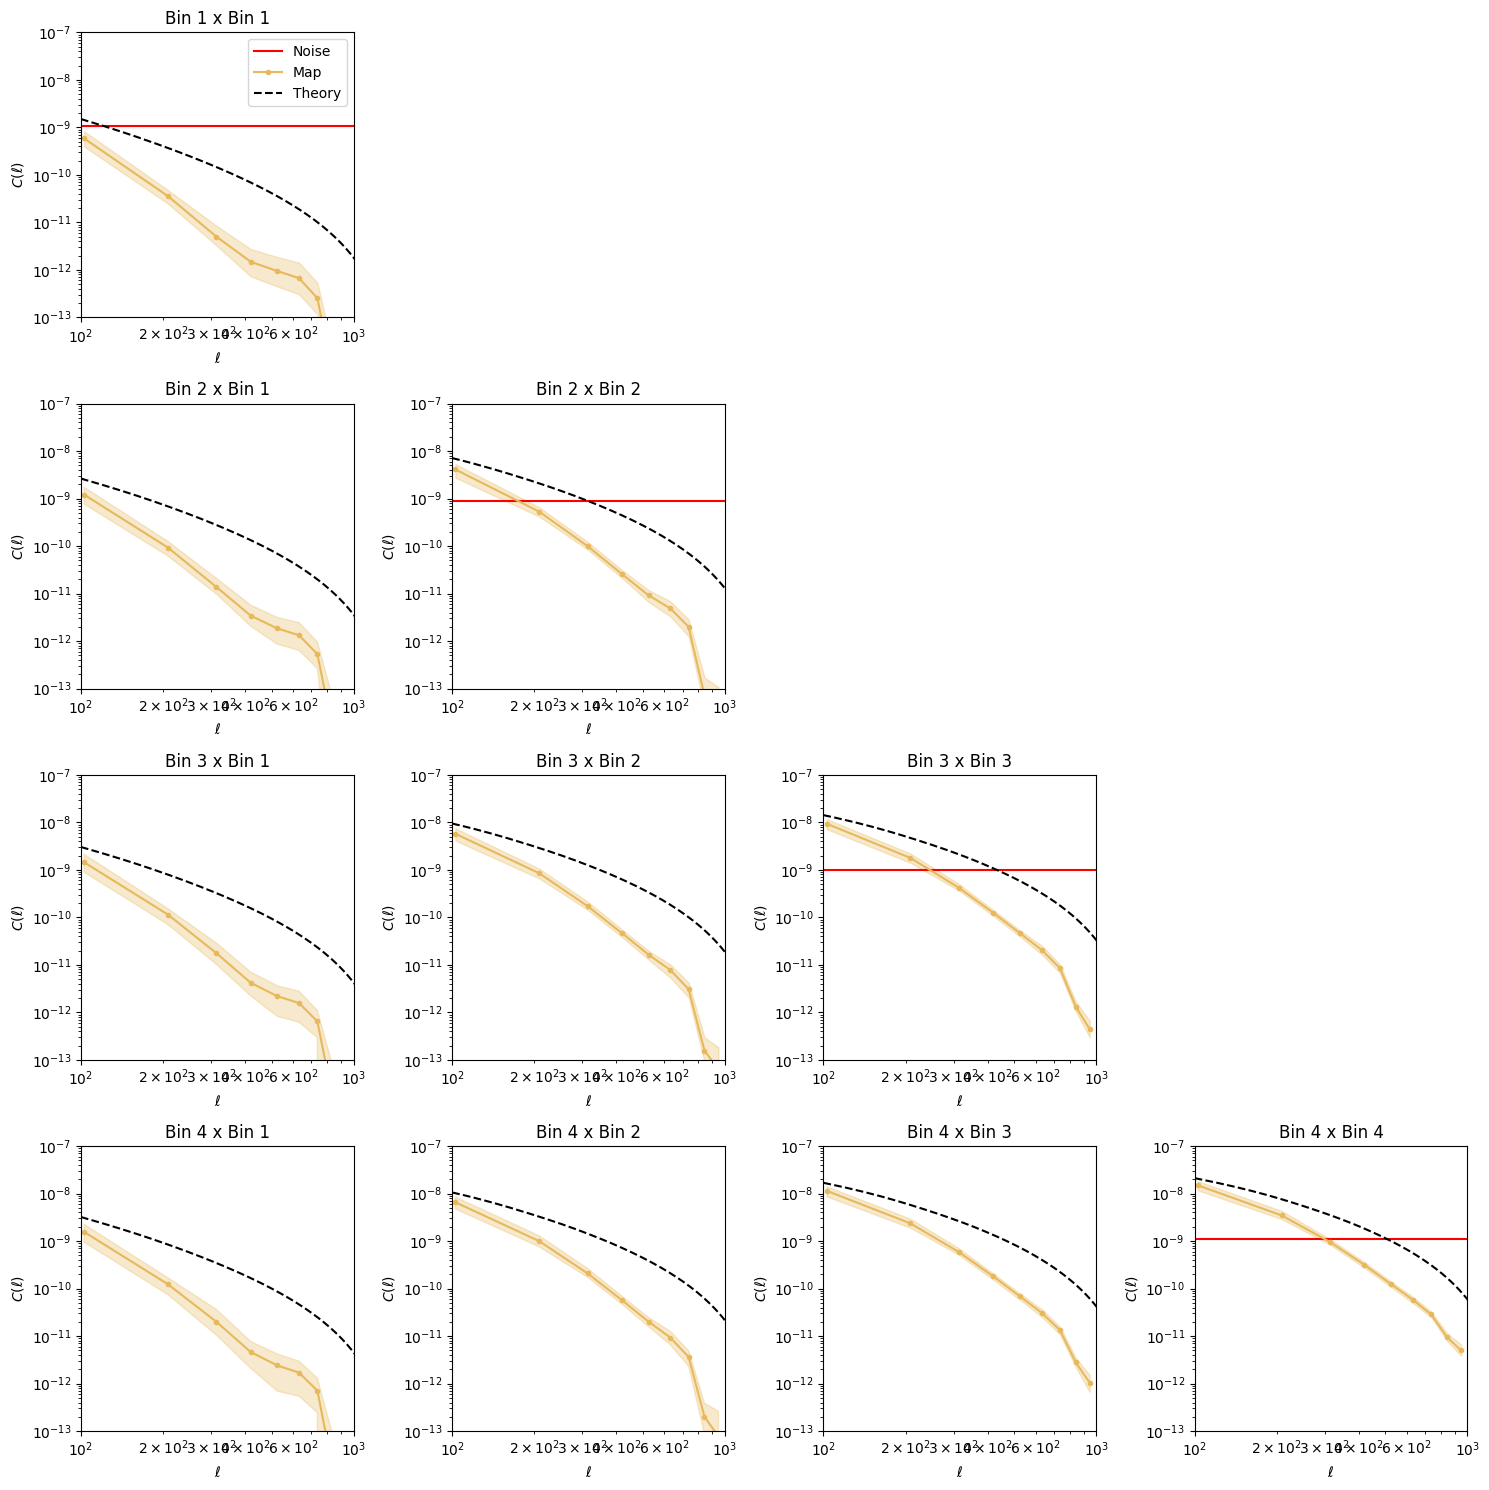

In [10]:
fig, ax = plt.subplots(nbins, nbins, figsize=(15,15))
col = cmr.eclipse([0.,0,0.55,0.85])

for i in range(nbins):
    for j in range(nbins):
        if(j>i):
            ax[i,j].axis('off')
        else:
            ax[i,j].set_title('Bin %d x Bin %d'%(i+1,j+1))
            ax[i,j].set_xlabel('$\ell$')
            ax[i,j].set_ylabel('$C(\ell)$')
            ax[i,j].set_xlim(100., 1000.)
            ax[i,j].set_ylim(1e-13, 1e-7)
            ax[i,j].loglog(ell_theory, Cl_noise_theory[:,i,j], label='Noise', color='red')
            if i==j:
                ax[i,j].loglog(ell_sample, Cl_mean_auto[i], '.-', color=col[3], label='Map')
                ax[i,j].loglog(ell_theory, Cl_mean_theory[:,i,j], '--',  color=col[1], label='Theory')
                ax[i,j].fill_between(ell_sample, Cl_lower_auto[i], Cl_upper_auto[i], color=col[3], alpha=0.3)
            else:
                ax[i,j].loglog(ell_sample, Cl_mean_sample_cross[:,i,j], '.-', color=col[3], label='Map')
                ax[i,j].loglog(ell_theory, Cl_mean_theory[:,i,j], '--',  color=col[1], label='Theory')
                ax[i,j].fill_between(ell_sample, Cl_lower_sample_cross[:, i,j], Cl_upper_sample_cross[:,i,j], color=col[3], alpha=0.3)

ax[0,0].legend()
plt.tight_layout()
plt.show()